# Prophet Model
### Goals

Our goals is to predict last 14 days worth of sales with using the Prophet model.

### Steps
* 1.Collecting Data 
* 2.Split Data
* 3.Train Model
* 4.Predict
* 5.Validate Model
* 6.Conclusion

### Introduction
In this notebook we will use **Prophet** Model for prediction. In this model 
we will use the models default parameters.

First of all, I must say that all classes and functions are
already created in this directory but I will show you the codes and 
usage anyway.

First of all we have to define dataset on which we will be working on.
We will be using database to collect data from.


## 1. Collecting data
So first step will be to import some libraries and load some files

In [1]:
import pandas as pd
from database.database import Database
from fbprophet import Prophet

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

Now we can prepare select query and create database Object.

In [2]:
database = Database('../../../database/database.ini')

query = f"""select it.invoice_date date, sum(ipt.quantity) sale
            from retail_data.invoice it
            inner join retail_data.invoice_product ipt 
                on it.invoice_no = ipt.invoice_no
            where it.customer_id <> 'NaN' 
            and left(it.invoice_no,1)<>'C'
            group by (it.invoice_date)
            order by it.invoice_date   """

We are collecting data where Customer are valid users and their cells is not null.
Everything is ready, now we can collect some data from database

In [3]:
select = database.select(query)

Because database select query returns list we need to transform it into **Dataframe**.

In [4]:
select = database.select(query)
sales = pd.DataFrame(select, columns=['Date', 'Sale'])
sales['Date'] = pd.to_datetime(sales['Date'])

sales = sales.rename(columns={'Date':'ds', 'Sale':'y'})
    
sales.head()

,ds,y
0,2009-12-01,24437
1,2009-12-02,29783
2,2009-12-03,48033
3,2009-12-04,20069
4,2009-12-05,5119


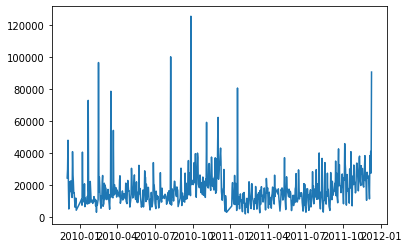

In [5]:
plt.plot(sales['ds'],sales['y'])

As you can see we have two columns with changed column names. **ds** is Date and **y** is sales. We have
change column names because prophet model can not train model until those names are present. As I said we have
two column. Dates and Daily Sales.
## 2. Split Data
Now we can split data. One part will be for validation and the other will be for train.
Our validation data will be last 14 days
 

In [6]:
split_point = len(sales) - 14
dataset, validation = sales[0:split_point], sales[split_point:]

## 3. Train Model
Now data preparation is done. Now we can finalize ARIMA model. 
Because we use the most basic form of **Prophet**  we will create it within this notebook.
Lets create and train model.


In [7]:
model = Prophet()
model.fit(dataset)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 4. Predict

Now we have model and can predict some sales. The function which will be predicting future 
sales are already created and I will share the code of that function with you.

As you can see there, this function requires validation dataset, because it need to collect the dates 
that the function has to predict. It is date based model. With this function we can predict 14 days worth of 
sales which is our goal. 
Now lets predict it

In [8]:
from models.regression.prophet_model.predict_prophet import predict_prophet

forecast = predict_prophet(model, validation)

         Date          Sale
0  2011-11-24  27763.298484
1  2011-11-25  20600.431665
2  2011-11-27  16328.580585
3  2011-11-28  25268.828016
4  2011-11-29  25112.407953
5  2011-11-30  24357.614432
6  2011-12-01  28098.111742
7  2011-12-02  20935.244923
8  2011-12-04  16663.393843
9  2011-12-05  25603.641274
10 2011-12-06  25447.221211
11 2011-12-07  24692.427690
12 2011-12-08  28432.925000
13 2011-12-09  21270.058181


## 5. Validate Model
With this we can predicted some values. Now lets validate the model. The function 
that validates this model will be like that: 

It is easiest way one of the easiest way to check the results, but of course you can change it
anyway you like it. First of all lets make sure that the type of validation data and the prediction
data is the same before we process

In [9]:
validation_data = validation['y'].to_numpy().astype(float)
prediction_data = forecast['Sale'].to_numpy()

Now we can call that function and see the results.

In [10]:
from models.regression.prophet_model.validate_prophet import validate_prophet

validate_prophet(validation_data, prediction_data)

RMSE: 19653.776


19653.776356618357


## 6. Conclusion
As you can see RMSE is rather high. That is because our data has no seasonality or trend, 
In addition to this the parameters was default and we did not change anything. So by changing 
some parameters you might get better result than this.